In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model

import os
import time


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# data load
train_dir='/kaggle/input/chili-pepper/Kaggle_upload/'


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
#ds_health =glob.glob(train_dir + './Healthy/*.jpg') + glob.glob(train_dir + './Healthy/*.JPG')+ glob.glob(train_dir + './Healthy/*.JPEG') + glob.glob('/kaggle/input/aihub-healthy/*')
#ds_anth =glob.glob(train_dir + './Anthracnose/*.jpg') + glob.glob(train_dir + './Anthracnose/*.JPG')+ glob.glob(train_dir + './Anthracnose/*.JPEG') 

#leaf
ds_health = glob.glob('/kaggle/input/aihub-healthy/*')
ds_pm = glob.glob('/kaggle/input/aihub-powderymildew/*')
ds_bs = glob.glob('/kaggle/input/bacterial-spot/*')
ds_v = glob.glob('/kaggle/input/pepmov/*')

In [5]:
print(len(ds_health))
print(len(ds_pm))
print(len(ds_bs))
print(len(ds_v))

999
915
999
999


In [ ]:
# 갯수 지정
import random
random.seed(42)

# 랜덤 200개씩 총 400개로 학습
ds_health = random.sample(ds_health, 1000)
ds_anth = random.sample(ds_anth, 1000)



In [ ]:
print(len(ds_health), len(ds_anth))
# print(len(t_health),len(t_anth))

In [6]:
# Define data preprocessing and data_generator

def create_data_generators(train_df, valid_df, test_df, batch_size, image_size):

    # Define a function to crop the image
    def crop_image(img):
        # get the shape of the input image
        h, w, _ = img.shape
        

        # set the desired crop size
        crop_size = 224

        # calculate the starting point of the crop
        start_y = int((h - crop_size) / 2)
        start_x = int((w - crop_size) / 2)

        # crop the image
        crop_img = img[start_y:start_y + crop_size, start_x:start_x + crop_size, :]

        return crop_img

    # Define the ImageDataGenerator with the preprocessing function for training data
    train_generator = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=20,
        rescale=1/255.0,
        preprocessing_function=crop_image
    )

    # Flow from DataFrame using train_generator for training data
    train_generator_iterator = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='label',
        target_size=(image_size, image_size),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True
    )
    train_batch, label_batch = next(train_generator_iterator)

    # Define the ImageDataGenerator with rescaling and preprocessing for validation data
    valid_generator = ImageDataGenerator(
       rescale=1/255.0,
       preprocessing_function=crop_image
    )

   # Flow from DataFrame using valid_generator for validation data
    valid_generator_iterator = valid_generator.flow_from_dataframe(
       dataframe=valid_df,
       x_col='path',
       y_col='label',
       target_size=(image_size, image_size),
       class_mode="categorical",
       batch_size=batch_size,
       shuffle=True
   )
    valid_batch, valid_label_batch = next(valid_generator_iterator)

   # Define the ImageDataGenerator with only rescaling for test data
    test_generator = ImageDataGenerator(rescale=1/255.0)

   # Flow from DataFrame using test_generator for test data
    test_generator_iterator = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='path',
        y_col='label',
        target_size=(image_size, image_size),
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=True)
    test_batch, test_label_batch = next(test_generator_iterator)

    return train_generator_iterator, valid_generator_iterator,test_generator_iterator,test_batch




In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

# train_df
train_path = ds_health + ds_pm +ds_bs + ds_v
train_label = ["healthy" for _ in range(len(ds_health))] + ["powdery_mildew" for _ in range(len(ds_pm))] + ["bacterial_spot" for _ in range(len(ds_bs))] + ["PepMoV" for _ in range(len(ds_v))]
train_df = pd.DataFrame({"path":train_path, "label":train_label})

# Splitting into train and test sets
train_df, test_df = train_test_split(train_df, test_size=0.1,stratify=train_df['label'], random_state=42)
# Splitting into train and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.3, stratify=train_df['label'], random_state=42)


print(train_df['label'].value_counts())
print(valid_df['label'].value_counts())
print(test_df['label'].value_counts())


label
PepMoV            630
bacterial_spot    629
healthy           629
powdery_mildew    576
Name: count, dtype: int64
label
bacterial_spot    270
healthy           270
PepMoV            269
powdery_mildew    247
Name: count, dtype: int64
label
bacterial_spot    100
healthy           100
PepMoV            100
powdery_mildew     92
Name: count, dtype: int64


In [8]:
# Reset index of df
# train_df.reset_index(drop=True, inplace=True)
# valid_df.reset_index(drop=True, inplace=True)
# test_df.reset_index(drop=True, inplace=True)

# Call the function to create data generators
train_gen_iter, valid_gen_iter,test_gen_iter,test_batch  = create_data_generators(train_df=train_df,valid_df=valid_df,test_df=test_df,batch_size=BATCH_SIZE,image_size=IMAGE_SIZE)


Found 2464 validated image filenames belonging to 4 classes.
Found 1056 validated image filenames belonging to 4 classes.
Found 392 validated image filenames belonging to 4 classes.


In [ ]:
import matplotlib.pyplot as plt

# 첫 번째 배치의 데이터를 가져옵니다.
images, labels = next(train_gen_iter)

# 클래스 별 레이블을 가져옵니다.
class_indices = train_gen_iter.class_indices
labels_dict = {v: k for k, v in class_indices.items()}

# 이미지와 레이블을 시각화합니다.
fig, axes = plt.subplots(1, 5, figsize=(20,20))
axes = axes.flatten()

for img, lbl, ax in zip(images, labels, axes):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(labels_dict[np.argmax(lbl)])

plt.tight_layout()
plt.savefig('dataset.png',dpi=300)
plt.show()


In [9]:
# Define model list
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam ,AdamW, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.metrics import AUC

from tensorflow.keras.applications import Xception, ResNet50V2, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
import tensorflow as tf


def create_model(model_type='efficientnetb0', in_shape=(224, 224, 3), n_classes=4):
    tf.keras.backend.clear_session()
    input_tensor = Input(shape=in_shape)
    
    # Connect input tensor to rescale and resize model
    if model_type == 'resnet50v2':
        base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'resnet152v2':
        base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'xception':
        base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb3':
        base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb5':
        base_model = tf.keras.applications.EfficientNetB5(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb7':
        base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'vgg16':
        base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)  # 추가된 부분
    elif model_type == 'vgg19':
        base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type =='mobilenet':
        base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False, weights='imagenet', input_tensor=input_tensor)
    x = base_model.output
    x = Flatten()(x)
    # x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(units=n_classes, activation='sigmoid')(x)
    model = Model(inputs=input_tensor, outputs=preds)


    return model

In [10]:
# Define model and run

def train_model(model_name,model_type, image_size, train, valid):
    model = create_model(model_type=model_type, in_shape=(image_size, image_size, 3))
    root_logdir = os.path.join(os.curdir, "my_logs")

    def get_run_logdir():
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S_" + model_name)
        return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()
    checkpoint_cb = ModelCheckpoint( model_name + "_model.h5", monitor="val_loss", save_best_only=True,
                                     verbose=1)
    early_stopping_cb = EarlyStopping(monitor="val_loss", patience=10, verbose=1,
                                      restore_best_weights=False)
    reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5,
                                     mode="min", verbose=1)

    model.compile(optimizer=AdamW(0.001), loss="categorical_crossentropy", metrics=['accuracy'])
    
    history = model.fit(train,
                        validation_data=valid,
                        epochs=100,
                        callbacks=[checkpoint_cb, early_stopping_cb,reduce_lr_cb])
    return model,history

In [11]:
model, history = train_model(model_name='mobilenet_4class_AdamW',model_type='mobilenet', 
                             image_size=IMAGE_SIZE, 
                             train=train_gen_iter,
                             valid=valid_gen_iter)

17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/100
77/77 [==============================] - ETA: 0s - loss: 3.4045 - accuracy: 0.8007
Epoch 1: val_loss improved from inf to 14.40289, saving model to mobilenet_4class_AdamW_model.h5
77/77 [==============================] - 432s 5s/step - loss: 3.4045 - accuracy: 0.8007 - val_loss: 14.4029 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 2/100
77/77 [==============================] - ETA: 0s - loss: 0.1638 - accuracy: 0.9521
Epoch 2: val_loss improved from 14.40289 to 0.30056, saving model to mobilenet_4class_AdamW_model.h5
77/77 [==============================] - 322s 4s/step - loss: 0.1638 - accuracy: 0.9521 - val_loss: 0.3006 - val_accuracy: 0.9451 - lr: 0.0010
Epoch 3/100
77/77 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9704
Epoch 3: val_loss improved from 0.30056 to 0.10184, saving model to mobilenet_4class_AdamW_model.h5
77/77 [==============================] - 291s 4s/step - loss: 0.1

In [ ]:
from tensorflow.keras.models import load_model

model_path = '/kaggle/input/load-model/my_best_center_crop_xception_all_model.h5'
model = load_model(model_path)
name = 'xception_all'

In [12]:
# Accuracy and loss graph

# Function to plot the training and validation accuracy and loss curves
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy curves
    ax1.plot(acc, label='Training Accuracy')
    ax1.plot(val_acc, label='Validation Accuracy')
    ax1.legend(loc='lower right')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')

    # Plot loss curves
    ax2.plot(loss, label='Training Loss')
    ax2.plot(val_loss, label='Validation Loss')
    ax2.legend(loc='upper right')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    
    plt.savefig("acc_loss.jpg", dpi=500)

    plt.show(history)


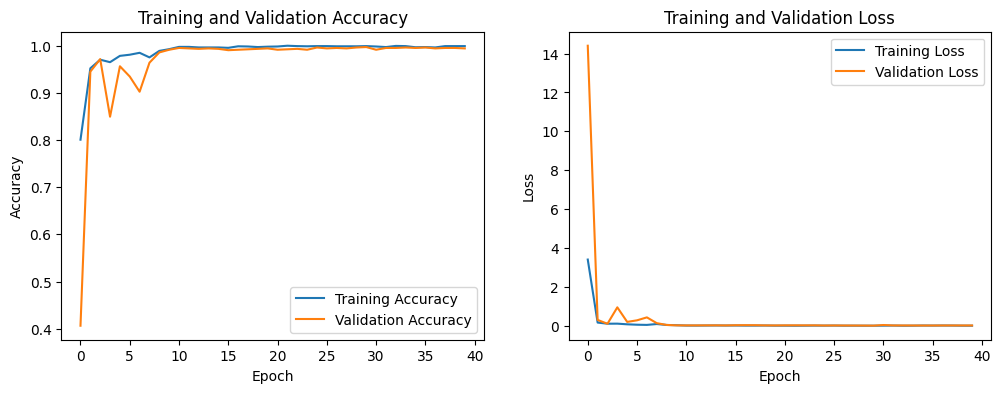

In [13]:
plot_metrics(history)

In [17]:
from sklearn.preprocessing import LabelBinarizer
# Create a LabelBinarizer object
lb = LabelBinarizer()

# Fit the label binarizer to the label column
lb.fit(test_df['label'])

# Transform the label column to binary list
label_list = lb.transform(test_df['label']).tolist()

# Flatten the list of ground truth labels and convert to numpy array
true_labels = np.ravel(label_list)

# test_df['label']와 predicted_labels 비교
true_labels = test_df['label'].astype(int)  #
predicted_labels = model.predict(test_gen_iter)
predicted_labels = np.argmax(predicted_labels, axis=1)  # 모델의 출력을 가장 높은 확률을 가진 클래스로 변환


ValueError: invalid literal for int() with base 10: 'bacterial_spot'

In [18]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the label encoder to the label column
le.fit(test_df['label'])

# Transform the label column to encoded labels
true_labels = le.transform(test_df['label'])

# test_df['label']와 predicted_labels 비교
predicted_labels = model.predict(test_gen_iter)
predicted_labels = np.argmax(predicted_labels, axis=1)  # 모델의 출력을 가장 높은 확률을 가진 클래스로 변환


13/13 [==============================] - 46s 4s/step


In [19]:
from sklearn.metrics import classification_report
report = classification_report(true_labels, predicted_labels)

### Classification Report

In [20]:
#fixed with wrtn
import csv
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def generate_classification_report(model,name):
#     # Create a LabelBinarizer object
#     lb = LabelBinarizer()

#     # Fit the label binarizer to the label column
#     lb.fit(test_df['label'])

#     # Transform the label column to binary list
#     label_list = lb.transform(test_df['label']).tolist()

#     # Flatten the list of ground truth labels and convert to numpy array
#     true_labels = np.ravel(label_list)

#     # Use the model to predict the classes of the test data
#     predicted_labels = model.predict(test_gen_iter)

#     # Convert predicted labels to integer format
#     predicted_labels = tf.argmax(predicted_labels, axis=1).numpy()

#     # Get classification report (including F1 score, precision, and recall)
#     report = classification_report(true_labels, predicted_labels)
    
#     print(report)    
    
    with open(name+'_report.csv', 'w') as file:
        writer = csv.writer(file)
        for line in report.split('\n'):
            writer.writerow(line.split(','))
        
        evaluation_results = model.evaluate(test_gen_iter)
        evaluation_results_header = ['Metric', 'Value']
            
        writer.writerow(['Loss', evaluation_results[0]])
        writer.writerow(['Accuracy', evaluation_results[1]])
        # 정확도(accuracy)를 계산합니다.
        accuracy = accuracy_score(true_labels, predicted_labels)
        writer.writerow(['Accuracy_score', accuracy])

        # 정밀도(precision)를 계산합니다.
        precision = precision_score(true_labels, predicted_labels,average='micro')
        writer.writerow(['Precision', precision])

        # 재현율(recall)를 계산합니다.
        recall = recall_score(true_labels, predicted_labels,average='micro')
        writer.writerow(['Recall', recall])

        # F1-스코어(F1-score)를 계산합니다.
        f1 = f1_score(true_labels, predicted_labels,average='micro')
        writer.writerow(['F1_score', f1])

        # 결과를 출력합니다.
        print("정확도: {:.4f}".format(accuracy))
        print("정밀도: {:.4f}".format(precision))
        print("재현율: {:.4f}".format(recall))
        print("F1-스코어: {:.4f}".format(f1))


average='binary' 설정은 이진 분류 문제에 대해서만 사용할 수 있습니다. 다중 클래스 분류 문제에는 average 매개변수에 'micro', 'macro', 'weighted' 등 다른 설정을 선택해야 합니다.
'micro': 클래스별 통계치를 계산하지 않고 모든 클래스의 예측 결과를 하나로 합쳐서 평가합니다.
'macro': 클래스별로 평가 지표를 계산한 후 평균을 내어 전체적인 평가 지표를 계산합니다. 클래스별 샘플 수에 관계없이 모든 클래스를 동등하게 다룹니다.
'weighted': 클래스별로 평가 지표를 계산한 후 각 클래스의 샘플 수에 가중치를 부여하여 평균을 계산합니다. 클래스별 샘플 수가 다를 때 유용합니다.

In [21]:
name='mobilenet_4class_AdamW'
generate_classification_report(model=model,name='mobilenet_4class_AdamW')

13/13 [==============================] - 32s 2s/step - loss: 0.0052 - accuracy: 0.9974
정확도: 0.1964
정밀도: 0.1964
재현율: 0.1964
F1-스코어: 0.1964


### Confusion Matrix

In [22]:
# Define confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

def generate_confusion_matrix(model,name):
    # create a LabelBinarizer object
   

    # Create a LabelEncoder object
    le = LabelEncoder()

    # Fit the label encoder to the label column
    le.fit(test_df['label'])

    # Transform the label column to encoded labels
    true_labels = le.transform(test_df['label'])

    # Transform the label column to binary list
    label_list = le.transform(test_df['label']).tolist()

    # Flatten the list of ground truth labels and convert to numpy array
    true_labels = np.ravel(label_list)
    # Use the model to predict the classes of the test data
    predicted_labels = model.predict(test_gen_iter)

    # Convert predicted labels to integer format
    predicted_labels = tf.argmax(predicted_labels, axis=1).numpy()

    # Get confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    print(cm)
    
    class_names = list(test_gen_iter.class_indices.keys())
    
    # Plot the confusion matrix
    plt.imshow(cm, cmap=plt.cm.GnBu, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(class_names))-0.5
    plt.xticks(tick_marks, class_names, rotation=20)
    plt.yticks(tick_marks, class_names)
    
    plt.xlabel('Predicted Label', labelpad=25)
    plt.ylabel('True Label')

    thresh = cm.max()-20
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i,j], "d"), ha="center", va="center",
                    color="white" if cm[i,j] > thresh else "black", fontsize=16)

     # Save the figure as a JPG image
    plt.savefig(name +'_confusion_matrix.jpg', dpi=500,bbox_inches='tight')


13/13 [==============================] - 35s 3s/step
[[36 31 16 17]
 [34 19 18 29]
 [33 25 15 27]
 [28 25 19 20]]


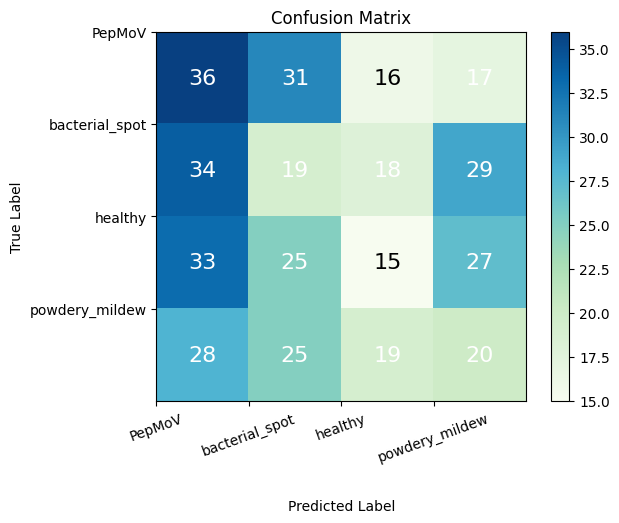

In [23]:
name='mobilenet_4class_Adam_W'
generate_confusion_matrix(model=model,name=name)

### t-SNE Visualization

In [27]:

from sklearn.manifold import TSNE

def extract_features(model, data):
    # 주어진 모델의 입력과 'global_average_pooling2d' 레이어의 출력을 연결하는 모델, 이를 통해 모델의 특성을 추출
    feature_extractor = Model(inputs=model.input, outputs=model.get_layer('flatten').output)
    features = feature_extractor.predict(data)
    return features

# 모델과 데이터로부터 특성 추출
features = extract_features(model,test_gen_iter)
# TSNE를 사용하여 2차원으로 차원 축소
tsne = TSNE(n_components=2,perplexity=5).fit_transform(features)

13/13 [==============================] - 31s 2s/step


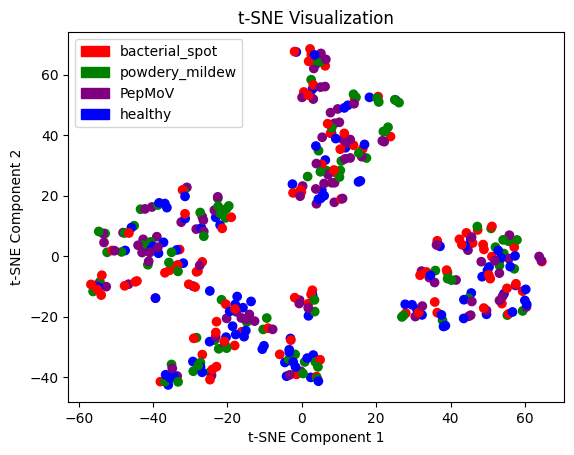

In [28]:
# 레이블에 따라 색상 다르게


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 시각화할 데이터 포인트의 색상과 레이블 설정
colors_per_class = {
    'bacterial_spot': 'red',
    'powdery_mildew' : 'green',
    'PepMoV': 'purple',
    'healthy': 'blue'
}

# 시각화할 데이터 포인트의 색상 저장하는 리스트 초기화
scatter_colors = []

# test_df의 각 데이터 포인트에 대해 색상을 저장
for _, data_point in test_df.iterrows():
    color = colors_per_class[data_point['label']]
    scatter_colors.append(color)

# 산점도 그리기
plt.scatter(tsne[:, 0], tsne[:, 1], c=scatter_colors)

# 그래프 제목 설정
plt.title("t-SNE Visualization")

# x축, y축 레이블 설정
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# 범례 항목 생성
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in colors_per_class.items()]

# 범례 표시
plt.legend(handles=legend_patches)

# 그래프 출력
plt.savefig(name+'_t-sne.png',dpi=500)
plt.show()


### PCA Visualization

In [25]:
from sklearn.decomposition import PCA

# PCA를 사용하여 2차원으로 차원 축소
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)


NameError: name 'features' is not defined

In [26]:
# 레이블에 따라 색상 다르게


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 시각화할 데이터 포인트의 색상과 레이블 설정
colors_per_class = {
    'bacterial_spot': 'red',
    'powdery_mildew' : 'green',
    'PepMoV': 'purple',
    'healthy': 'blue'
}

# 시각화할 데이터 포인트의 색상 저장하는 리스트 초기화
scatter_colors = []

# test_df의 각 데이터 포인트에 대해 색상을 저장
for _, data_point in test_df.iterrows():
    color = colors_per_class[data_point['label']]
    scatter_colors.append(color)

# 산점도 그리기
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=scatter_colors)

# 그래프 제목 설정
plt.title("PCA Visualization")

# x축, y축 레이블 설정
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# 범례 항목 생성
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in colors_per_class.items()]

# 범례 표시
plt.legend(handles=legend_patches)

# 그래프 출력
plt.savefig(name+'_pca.png',dpi=500)
plt.show()


NameError: name 'pca_result' is not defined

### GradCAM Visualization

In [ ]:
test_batch[0]

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

def gradcam_visualization(model, image, layer_name, class_index):
    # GradCAM을 위한 모델 생성
    grad_model = Model(inputs=model.input, outputs=(model.get_layer(layer_name).output, model.output))

    # 이미지 전처리
    img = np.expand_dims(image, axis=0)
    img = img.astype(np.float32) / 255.0

    # 특성 맵과 예측 결과 가져오기
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, class_index]

    # 클래스에 대한 gradient 계산
    grads = tape.gradient(loss, conv_outputs)[0]

    # 특성 맵과 gradient를 가중 평균하여 heatmap 생성
    weights = tf.reduce_mean(grads, axis=(0, 1))
    heatmap = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)

    # heatmap 후처리
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # heatmap을 원본 이미지 크기로 조정
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # heatmap을 원본 이미지에 적용하여 시각화
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

    return superimposed_img

# GradCAM 시각화 예시
class_index = 0  # 시각화할 클래스 인덱스
layer_name = 'global_average_pooling2d'  # 시각화할 레이어 이름
image = test_batch[0]  # 시각화할 이미지

visualization = gradcam_visualization(model, image, layer_name, class_index)
